In [1]:
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import h5py
import time

import os
from dotenv import load_dotenv
load_dotenv()

from data_manipulation.reading_util import load_ml_data_emb

2023-10-15 19:11:39.995232: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-15 19:11:40.037695: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-15 19:11:40.038399: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-15 19:11:40.779802: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Reading in esm2 embeddings

### Creating X and y
#### Reading in data (splitX.csv and esm2_splitX)

In [2]:
enzyme_csv_path = os.getenv("CSV30_ENZYMES")
esm2_enzymes_path = os.getenv("ESM2_ENZYMES_SPLIT_30")

X, y = load_ml_data_emb(path_to_esm2=esm2_enzymes_path, path_to_enzyme_csv=enzyme_csv_path)
print(len(y))
print(len(X))

LOG: 3 Sequences with aa O in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG: 15 Sequences with aa U in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG: 203 multifunctional enzymes with diff ec main classes in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG: 221 entries will be ignored
LOG: Data loaded in: 1.064 min
LOG: ESM2 of enzymes: 9204
LOG: Labels of enzymes: 9204
9204
9204


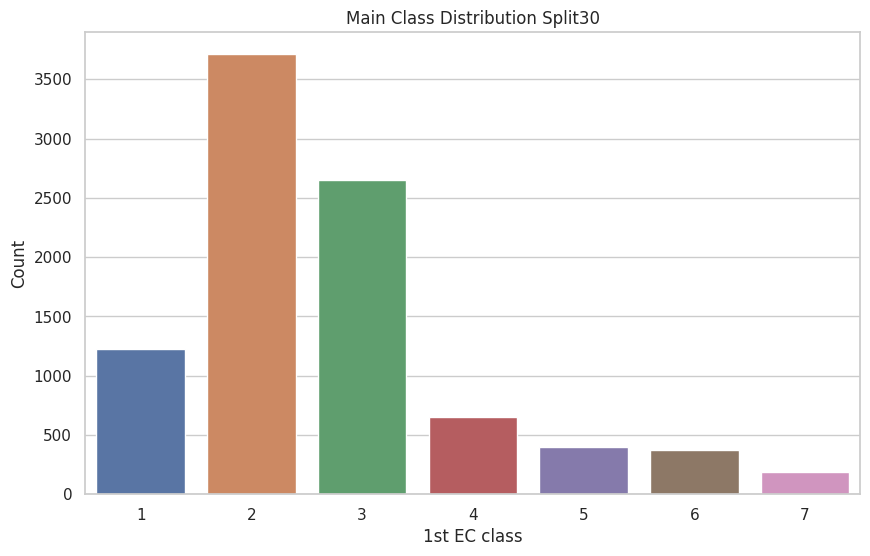

In [3]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.countplot(x=y)
plt.xticks([0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 7])

# Add labels and title
plt.xlabel("1st EC class")
plt.ylabel("Count")
plt.title("Main Class Distribution Split30")

# Show the plot
plt.show()

## Creating and training our CNN

### Splitting data into train and test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
# Our labels need to be one hot encoded
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=7)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=7)
print(y_test_encoded[0])

[0. 0. 1. 0. 0. 0. 0.]


In [5]:
# This is used for stopping the training precess in advance, if our model starts to overfit our training data
earl_stop = tf.keras.callbacks.EarlyStopping(patience=10)

In [6]:
# Initializing the model
model = tf.keras.models.Sequential()

# Adding input layer
model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(2560,)))

# Adding hidden layer
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=64, activation='relu'))

# Finally adding output layer using softmax as activation function
model.add(tf.keras.layers.Dense(units=7, activation='softmax'))  # Using softmax for multi-class classification

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [7]:
# Training the model
model.fit(x=X_train, y=y_train_encoded, epochs=50, validation_data=(X_test, y_test_encoded), callbacks = [earl_stop])

Epoch 1/50
202/202 [==============================] - 3s 13ms/step - loss: 1.4648 - val_loss: 1.2267
Epoch 2/50
202/202 [==============================] - 2s 12ms/step - loss: 1.1503 - val_loss: 0.9301
Epoch 3/50
202/202 [==============================] - 2s 11ms/step - loss: 0.9144 - val_loss: 0.8561
Epoch 4/50
202/202 [==============================] - 2s 11ms/step - loss: 0.8025 - val_loss: 0.7735
Epoch 5/50
202/202 [==============================] - 2s 11ms/step - loss: 0.7325 - val_loss: 0.6976
Epoch 6/50
202/202 [==============================] - 2s 11ms/step - loss: 0.6621 - val_loss: 0.6235
Epoch 7/50
202/202 [==============================] - 2s 11ms/step - loss: 0.5970 - val_loss: 0.6061
Epoch 8/50
202/202 [==============================] - 2s 11ms/step - loss: 0.5586 - val_loss: 0.5670
Epoch 9/50
202/202 [==============================] - 2s 11ms/step - loss: 0.5077 - val_loss: 0.5528
Epoch 10/50
202/202 [==============================] - 2s 11ms/step - loss: 0.4886 - val_lo

In [ ]:
def objective(trial):
    # Define hyperparameters to be optimized
    num_units_dense_1 = trial.suggest_int('num_units_dense_1', 32, 512)
    dropout_rate_1 = trial.suggest_float('dropout_rate_1', 0.0, 0.7)
    num_units_dense_2 = trial.suggest_int('num_units_dense_2', 32, 256)
    dropout_rate_2 = trial.suggest_float('dropout_rate_2', 0.0, 0.7)
    num_units_dense_3 = trial.suggest_int('num_units_dense_3', 16, 128)

    # Create the model with the suggested hyperparameters
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=num_units_dense_1, activation='relu', input_shape=(2560,)))
    model.add(tf.keras.layers.Dropout(dropout_rate_1))
    model.add(tf.keras.layers.Dense(units=num_units_dense_2, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate_2))
    model.add(tf.keras.layers.Dense(units=num_units_dense_3, activation='relu'))
    model.add(tf.keras.layers.Dense(units=7, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Split your data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=7)
    y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes=7)

    # Define early stopping callback
    early_stop = tf.keras.callbacks.EarlyStopping(patience=10)

    # Train the model
    history = model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded), epochs=25, callbacks=[early_stop], verbose=0)

    # Get the best validation loss
    val_loss = min(history.history['val_loss'])

    return val_loss


In [ ]:

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)  # You can adjust the number of trials as needed


In [ ]:

best_params = study.best_params
best_num_units_dense_1 = best_params['num_units_dense_1']
best_dropout_rate_1 = best_params['dropout_rate_1']
best_num_units_dense_2 = best_params['num_units_dense_2']
best_dropout_rate_2 = best_params['dropout_rate_2']
best_num_units_dense_3 = best_params['num_units_dense_3']

final_model = tf.keras.models.Sequential()
final_model.add(tf.keras.layers.Dense(units=best_num_units_dense_1, activation='relu', input_shape=(2560,)))
final_model.add(tf.keras.layers.Dropout(best_dropout_rate_1))
final_model.add(tf.keras.layers.Dense(units=best_num_units_dense_2, activation='relu'))
final_model.add(tf.keras.layers.Dropout(best_dropout_rate_2))
final_model.add(tf.keras.layers.Dense(units=best_num_units_dense_3, activation='relu'))
final_model.add(tf.keras.layers.Dense(units=7, activation='softmax'))
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=42)
# Our labels need to be one hot encoded
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=7)
y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes=7)

# Define early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(patience=10)

final_model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded), epochs=100, callbacks=[early_stop], verbose=1)


# Evaluation

<Figure size 1000x600 with 0 Axes>

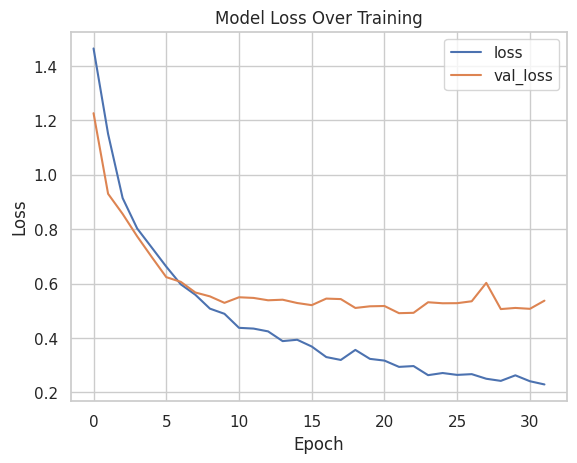

In [8]:
# Plotting loss (loss on train_data) and val_loss (loss on validation_data)
model_loss = pd.DataFrame(model.history.history)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
model_loss.plot()

plt.title('Model Loss Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [9]:
predictions = np.argmax(model.predict(X_test), axis=-1) # for multi class classification (using softmax)

87/87 [==============================] - 0s 2ms/step


In [10]:
counter = 0
for x,y in zip(y_test,predictions):
    if x == y:
        counter+=1
print("Correct predictions: ", counter)
print("Total samples predicted:", len(y_test))

Correct predictions:  2358
Total samples predicted: 2762


In [11]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       367
           1       0.88      0.92      0.90      1134
           2       0.88      0.90      0.89       789
           3       0.72      0.46      0.56       203
           4       0.71      0.61      0.66       110
           5       0.79      0.75      0.77       110
           6       0.72      0.69      0.71        49

    accuracy                           0.85      2762
   macro avg       0.79      0.75      0.76      2762
weighted avg       0.85      0.85      0.85      2762


In [12]:
def plot_report(report, y , predictions):
    """
    Plots results of model
    :param report: Report of model
    """
    
    class_0_metrics = report.split('\n')[2].split()[1:]
    class_1_metrics = report.split('\n')[3].split()[1:]
    class_2_metrics = report.split('\n')[4].split()[1:]
    class_3_metrics = report.split('\n')[5].split()[1:]
    class_4_metrics = report.split('\n')[6].split()[1:]
    class_5_metrics = report.split('\n')[7].split()[1:]
    class_6_metrics = report.split('\n')[8].split()[1:]

    metrics = [class_0_metrics,
               class_1_metrics,
               class_2_metrics,
               class_3_metrics,
               class_4_metrics,
               class_5_metrics,
               class_6_metrics
               ]
    
    precs = []
    recs = []
    f1_s = []
    
    for class_m in metrics:
        precision = float(class_m[0])
        recall = float(class_m[1])
        f1_score = float(class_m[2])
        precs.append(precision)
        recs.append(recall)
        f1_s.append(f1_score)

    class_names = [1,2,3,4,5,6,7]

    # Create subplots for accuracy, precision, and F1
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Plot accuracy for each class
    ax1.bar(class_names, recs)
    ax1.set_title("Recall")
    ax1.set_xlabel("Main Class")


    # Plot precision for each class
    ax2.bar(class_names, precs)
    ax2.set_title("Precision")
    ax2.set_xlabel("Main Class")

    # Plot F1 score for each class
    ax3.bar(class_names, f1_s)
    ax3.set_title("F1 Score")
    ax3.set_xlabel("Main Class")

    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()


    conf_matrix = confusion_matrix(y, predictions)

    # Create a confusion matrix heatmap
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.2)  # Adjust font size as needed
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

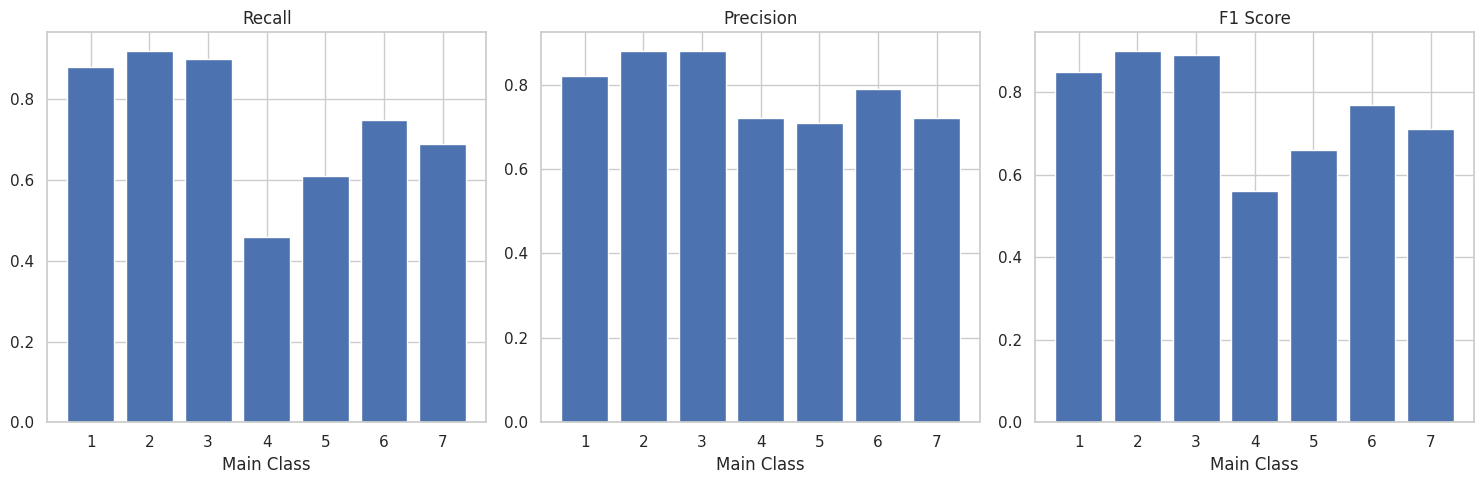

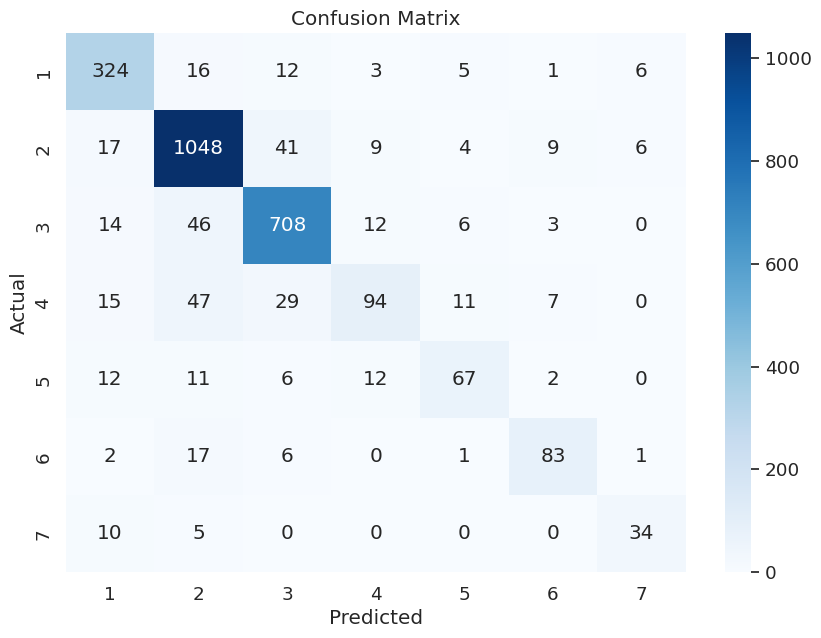

In [13]:
plot_report(report, y_test, predictions)

In [15]:
model.save("cnn_v5_1_split30.keras")

# Importing and using my model

## 2. Predict new data
The data needs to be the same shape as the training/test data used to train the model.
The unlabeled embeddings need to be imported into a dataframe and then we need to create a feature column for each 
value of the embedding.


In [18]:
def validate_on_test_data(path_to_enzyme_test_csv: str, path_to_enzyme_test_esm2: str, path_to_cnn_model):
    """
    Easy way to test a model on test dataset
    :param path_to_enzyme_test_csv: Path to test.csv
    :param path_to_enzyme_test_esm2: Path to test_esm2.h5
    :param path_to_cnn_model: Path to model of choice
    """
    
    # Load model and test data
    model = tf.keras.models.load_model(path_to_cnn_model)
    
    X, y = load_ml_data_emb(path_to_esm2=path_to_enzyme_test_esm2, path_to_enzyme_csv=path_to_enzyme_test_csv)



    print("\n\n============================================= PREDICTING TEST DATA =============================================\n\n") 
    
    predictions = np.argmax(model.predict(X), axis=-1) # for multi class classification (using softmax)
   
    print("LOG: Making predictions: DONE")
    
    # Evaluation
    counter = 0
    for label, predict_label in zip(y,predictions):
        if label == predict_label:
            counter+=1
            
    print("LOG: Correct predictions: ", counter)
    print("LOG: Total samples predicted:", len(y))
    print("\n\n\n")


    report = classification_report(y, predictions)
    
    print(report)
    
    plot_report(report, y, predictions)


    # Overview of class dist
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
    sns.countplot(x=y, palette="Set3")

    plt.xticks([0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 7])
    plt.xlabel("EC class")
    plt.ylabel("Count")
    plt.title("Main Class Distribution")

    plt.show()



Data loaded in: 0.811 min


============================================= PREDICTING TEST DATA =============================================


226/226 [==============================] - 1s 2ms/step
LOG: Making predictions: DONE
LOG: Correct predictions:  6869
LOG: Total samples predicted: 7212
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       894
           1       0.96      0.98      0.97      2952
           2       0.97      0.96      0.96      2149
           3       0.90      0.82      0.86       515
           4       0.92      0.88      0.90       304
           5       0.96      0.93      0.94       233
           6       0.99      0.96      0.97       165

    accuracy                           0.95      7212
   macro avg       0.95      0.93      0.94      7212
weighted avg       0.95      0.95      0.95      7212


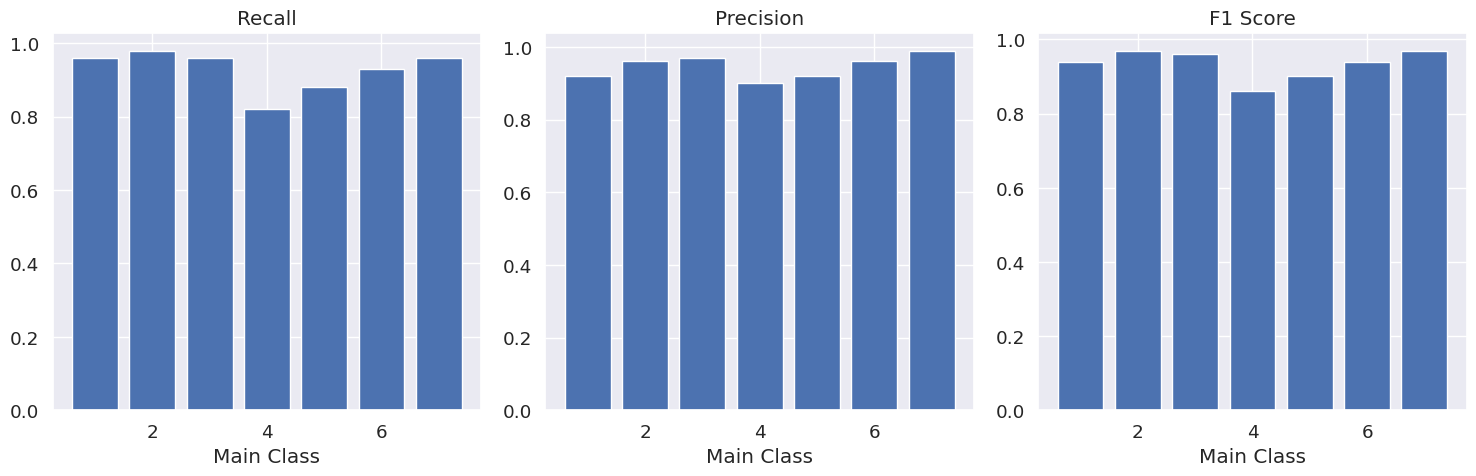

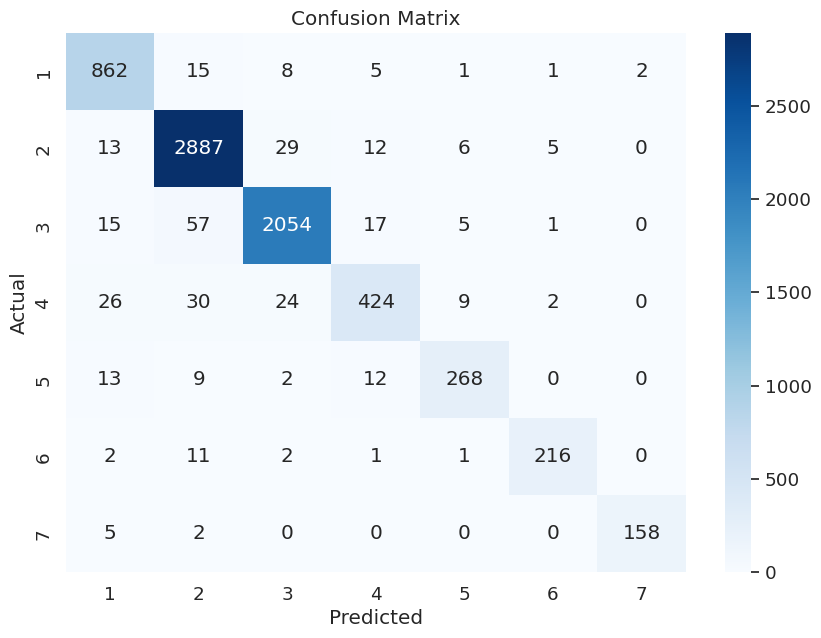

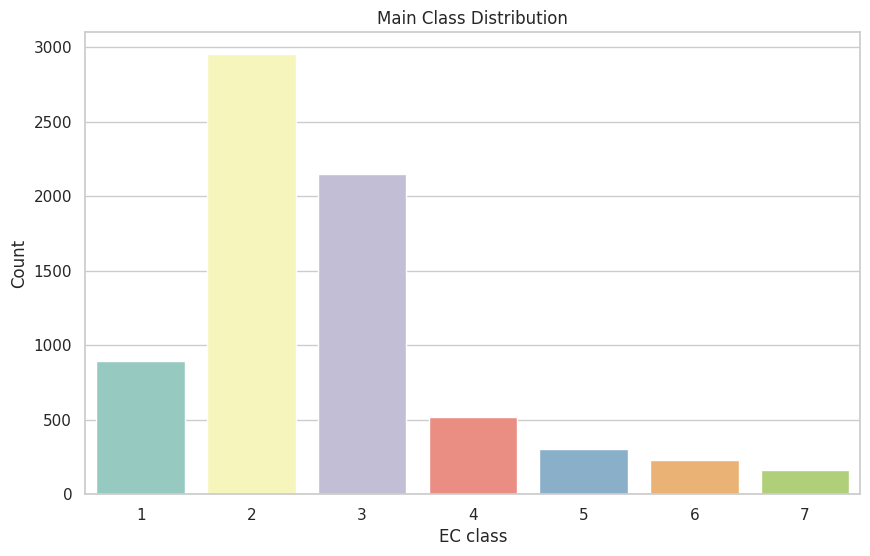

In [19]:
validate_on_test_data(path_to_enzyme_test_csv=os.getenv("CSV10_ENZYMES"),
                      path_to_enzyme_test_esm2=os.getenv("ESM2_ENZYMES_SPLIT_10"),
                      path_to_cnn_model="/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/cnn_v5_1_split100.keras")